In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pickle
import collections

In [2]:
# taken from International Tables for Crystallography
# order: a1, a2, a3, a4, b1, b2, b3, b4, c
import json
with open('./scattering_factors.json', 'r') as f:
    scattering_factors = json.load(f)

In [3]:
class Lattice:
    def __init__(self, material, id):
        
        # ID
        self.id = id
        
        # primitive cell parameters
        self.a = material['param'][0]
        self.b = material['param'][1]
        self.c = material['param'][2]
        self.alpha = material['param'][3]
        self.beta = material['param'][4]
        self.gamma = material['param'][5]
        
        # atomic sites
        self.elements = [specie['label'] for specie in material['sites']]
        self.fcoords = [specie['abc'] for specie in material['sites']]
        
    @property
    def primitive_vectors(self):

        angles = np.radians([self.alpha, self.beta, self.gamma])
        cos_alpha, cos_beta, cos_gamma = np.cos(angles)
        sin_alpha, sin_beta, sin_gamma = np.sin(angles)
        
        c1 = self.c * cos_beta
        c2 = (self.c * (cos_alpha - (cos_beta * cos_gamma))) / sin_gamma

        vector_a = np.array([self.a, 0, 0])
        vector_b = np.array([self.b * cos_gamma, self.b * sin_gamma, 0])
        vector_c = np.array([c1, c2, np.sqrt(self.c**2 - c1**2 - c2**2)])
        
        return np.vstack((vector_a, vector_b, vector_c))
    
    @property
    def reciprocal_vectors(self):
        return np.linalg.inv(self.primitive_vectors).T # * 2 * np.pi

        

In [4]:
class XRD(Lattice):
    def __init__(self, material, id, wavelength):
        super(XRD, self).__init__(material, id)
        self.wavelength = wavelength
    
    @property
    def points_in_sphere(self):
        
        radius = 2 / self.wavelength
    
        h_max = np.floor(radius / np.linalg.norm(self.reciprocal_vectors[0]))
        k_max = np.floor(radius / np.linalg.norm(self.reciprocal_vectors[1]))
        l_max = np.floor(radius / np.linalg.norm(self.reciprocal_vectors[2]))

        h_list = np.arange(-h_max, h_max + 1)  
        k_list = np.arange(-k_max, k_max + 1)
        l_list = np.arange(-l_max, l_max + 1)

        potential_hkl = np.asarray(list(product(h_list, k_list, l_list)))
        potential_hkl_cart = np.dot(potential_hkl, self.reciprocal_vectors)

        in_sphere = (np.abs(np.linalg.norm(potential_hkl_cart, axis=-1)) < radius)
        hkl = potential_hkl[in_sphere]
        d_hkl = np.linalg.norm(potential_hkl_cart[in_sphere], axis=-1)
        
        return hkl, d_hkl
    
    
    @property
    def unique_points_in_sphere(self):
        
        hkl, d_hkl = self.points_in_sphere
        unique_d, idx, multiplicity = np.unique(d_hkl.round(5), return_index=True, return_counts=True)
        unique_hkl = hkl[idx]
        
        return unique_hkl, unique_d, multiplicity

    
    @property
    def peak_intensities(self):
        
        peaks = {"two_theta":[], "intensity":[]}
        hkls, d_hkls, multiplicities = self.unique_points_in_sphere
        
        for hkl, d_hkl, multiplicity in zip(hkls, d_hkls, multiplicities):
            if d_hkl != 0:
                
                # peak locations
                theta = np.arcsin(self.wavelength * d_hkl / 2)
                two_theta = 2 * np.degrees(theta)
            
                # structure factor
                F_hkl = 0
                for element, fcoord in zip(self.elements, self.fcoords):
                    coeff = scattering_factors[element]
                    f = coeff[-1] + np.sum([coeff[i] * np.exp(- coeff[i + 4] * (d_hkl / 2) ** 2) for i in range(4)])
                    F_hkl += f * np.exp(2j * np.pi * np.dot(hkl, fcoord))

                # intensity
                lorentz_factor = (1 + np.cos(2 * theta) ** 2) / (np.sin(theta) ** 2 * np.cos(theta))
                I_hkl = multiplicity * lorentz_factor * (F_hkl * F_hkl.conjugate()).real
        
                peaks["two_theta"].append(two_theta)
                peaks["intensity"].append(I_hkl)
        
        return peaks

In [5]:
# Import data

rootdir = 'material_sites_no_xrd.pkl'

wavelength = 0.1542 * 10 # Angstrom
lattices = []
xrds = []
energies = []
with open(rootdir, 'rb') as f:
    material = pickle.load(f)
    for i, k in enumerate(material.keys()):
        lattices.append(Lattice(material[k], k))
        xrds.append(XRD(material[k], k, wavelength))
        energies.append(material[k]['energy'])

mp-1008676


<BarContainer object of 71 artists>

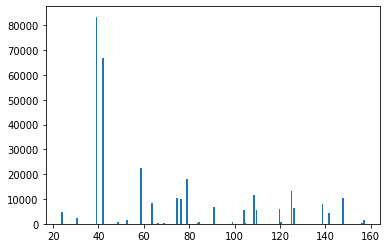

In [6]:
# sanity check with a relatively simple material
# https://legacy.materialsproject.org/materials/mp-1008676/

test_xrd1 = xrds[20]
print(test_xrd1.id)

plt.bar(test_xrd1.peak_intensities['two_theta'], test_xrd1.peak_intensities['intensity'])

mp-13738


<BarContainer object of 1288 artists>

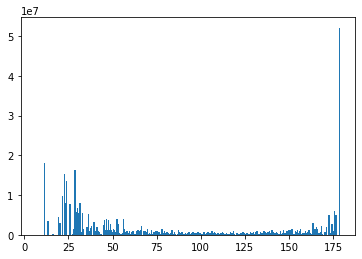

In [7]:
# sanity check with a relatively complex material
# https://legacy.materialsproject.org/materials/mp-13738/

test_xrd2 = xrds[251]
print(test_xrd2.id)

plt.bar(test_xrd2.peak_intensities['two_theta'], test_xrd2.peak_intensities['intensity'])

In [4]:
with open('material.pkl', 'rb') as f:
    material = pickle.load(f)
xrd = np.zeros((41100,1000)) 
for i, k in enumerate(material.keys()):
    xrd[i,:] = material[k]['xrd'][0]

22


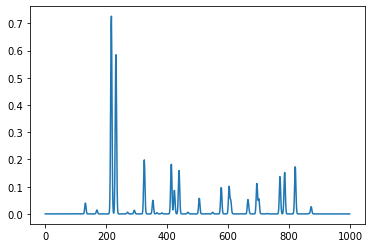

In [18]:
plt.plot(xrd[20,:])

from scipy.signal import find_peaks_cwt
# in case we need these peak information
def fine_peaks(x, window):
    x_peaks = find_peaks_cwt(x, np.arange(1,5), noise_perc=0.01)
    return x_peaks

print(len(fine_peaks(xrd[20,:], 2)))

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class XRDInverse(nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        self.input_dim = n_features
        self.hidden_dim = n_hidden
        self.output_dim = n_output
        self.seq_model = nn.RNN(n_features, n_hidden, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x, _ = self.seq_model(x)
        x = self.fc(x)
        return x


class XRDdataset(Dataset):
    def __init__(self, xrd_items):
        max_peak_length = 0
        self.mat_ids = []
        for k, v in xrd_items.items():
            self.mat_ids.append(k)
            max_peak_length = max(len(v['xrd_peaks']), max_peak_length)
        
        self.xrd_input = np.zeros(len(self.mat_ids), max_peak_length, 2)
        self.xrd_output = np.zeros(len(self.mat_ids), max_peak_length, 10)
        
        for k, v in xrd_items.items():
            self.xrd_input[k, :len(v['xrd_peaks']), 0] = v['xrd_peaks']
            self.xrd_input[k, :len(v['xrd_peaks']), 1] = v['xrd_gt'][v['xrd_peaks']]
            self.xrd_output[k, :len(v['xrd_peaks']), :] = v['xrd_parameters'][:len(v['xrd_peaks'])]
            

    def __len__(self):
        return len(self.mat_ids)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


1.10.1
